## Import Library

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Making Dummy Data

In [26]:
np.random.seed(42)

# daftar subjek
subjects = [
    "Pendidikan Agama", "Pendidikan Pancasila", "Bahasa Inggris", "Bahasa Mandarin",
    "Matematika (Umum)", "Biologi", "Fisika", "Kimia", "Geografi", "Sejarah",
    "Sosiologi", "Ekonomi", "Pendidikan Jasmani, Olahraga, dan Kesehatan",
    "Informatika", "Seni Musik", "Bahasa Indonesia"
]

# students yang bakal di generate
n_students = 5000

# Simulasi semester sekarang
low_count = int(0.2 * n_students)
mid_count = int(0.5 * n_students)
high_count = n_students - low_count - mid_count

low_avg = np.random.normal(loc=60, scale=5, size=low_count)
mid_avg = np.random.normal(loc=75, scale=5, size=mid_count)
high_avg = np.random.normal(loc=90, scale=5, size=high_count)

base_averages = np.concatenate([low_avg, mid_avg, high_avg])
base_averages = np.clip(base_averages, 0, 100)

# Simulasi skor subjek per murid
grades_current = np.array([
    base + np.random.normal(loc=0, scale=5, size=len(subjects))
    for base in base_averages
])
grades_current = np.clip(grades_current, 0, 100)

# dataframe
df = pd.DataFrame(grades_current, columns=subjects)
df['Rata-rata'] = df.mean(axis=1)

df[subjects] = df[subjects].round().astype(int)  # Convert subject scores to integers
df['Rata-rata'] = df['Rata-rata'].round(2) 

# Mask
low_mask = df['Rata-rata'] < 70
mid_mask = (df['Rata-rata'] >= 70) & (df['Rata-rata'] < 85)
high_mask = df['Rata-rata'] >= 85

df_next_sem = df[subjects].copy()

def add_noise(data, loc=0, scale=5):
    return np.clip(data + np.random.normal(loc=loc, scale=scale, size=data.shape), 0, 100)

# Low performers
indices = df[low_mask].index.to_numpy()
np.random.shuffle(indices)
n = len(indices)
df_next_sem.loc[indices[:int(0.5 * n)]] = add_noise(df_next_sem.loc[indices[:int(0.5 * n)]], loc=0, scale=3)
df_next_sem.loc[indices[int(0.5 * n):int(0.9 * n)]] = add_noise(df_next_sem.loc[indices[int(0.5 * n):int(0.9 * n)]], loc=5, scale=4)
df_next_sem.loc[indices[int(0.9 * n):]] = add_noise(df_next_sem.loc[indices[int(0.9 * n):]], loc=12, scale=5)

# Mid performers
indices = df[mid_mask].index.to_numpy()
np.random.shuffle(indices)
n = len(indices)
df_next_sem.loc[indices[:int(0.6 * n)]] = add_noise(df_next_sem.loc[indices[:int(0.6 * n)]], loc=0, scale=3)
df_next_sem.loc[indices[int(0.6 * n):int(0.9 * n)]] = add_noise(df_next_sem.loc[indices[int(0.6 * n):int(0.9 * n)]], loc=5, scale=4)
df_next_sem.loc[indices[int(0.9 * n):]] = add_noise(df_next_sem.loc[indices[int(0.9 * n):]], loc=-7, scale=5)

# High performers
indices = df[high_mask].index.to_numpy()
np.random.shuffle(indices)
n = len(indices)
df_next_sem.loc[indices[:int(0.8 * n)]] = add_noise(df_next_sem.loc[indices[:int(0.8 * n)]], loc=-3, scale=3)
df_next_sem.loc[indices[int(0.8 * n):]] = add_noise(df_next_sem.loc[indices[int(0.8 * n):]], loc=3, scale=2)

# pembulatan dan pergantian nama df
df_next_sem = df_next_sem.round().astype(int)
df_next_sem.columns = [col + " (Next Sem)" for col in df_next_sem.columns]

# kombinasi
df_final = pd.concat([df, df_next_sem], axis=1)
df_final['Rata-rata (Next Sem)'] = df_next_sem.mean(axis=1).round(2)

# Kategori berdasarkan performa dan perubahan
df_final['Kategori Performa'] = "Unlabeled"
df_final.loc[low_mask, 'Kategori Performa'] = "Low"
df_final.loc[mid_mask, 'Kategori Performa'] = "Mid"
df_final.loc[high_mask, 'Kategori Performa'] = "High"


low_mask2 = df_final['Rata-rata (Next Sem)'] < 70
mid_mask2 = (df_final['Rata-rata (Next Sem)'] >= 70) & (df_final['Rata-rata (Next Sem)'] < 85)
high_mask2 = df_final['Rata-rata (Next Sem)'] >= 85


df_final['Kategori Performa (Next Sem)'] = "Unlabeled"
df_final.loc[low_mask2, 'Kategori Performa (Next Sem)'] = "Low"
df_final.loc[mid_mask2, 'Kategori Performa (Next Sem)'] = "Mid"
df_final.loc[high_mask2, 'Kategori Performa (Next Sem)'] = "High"


# Tambahkan jumlah ketidakhadiran berdasarkan kategori performa
def generate_absences(current, future):
    if current == "Low" and future == "High":
        return np.random.randint(2, 4)
    elif current == "Low" and future == "Low":
        return np.random.randint(6, 12)
    elif current == "Low" and future == "Mid":
        return np.random.randint(5, 8)
    elif current == "Mid" and future == "Mid":
        return np.random.randint(4, 7)
    elif current == "Mid" and future == "High":
        return np.random.randint(0, 3)
    elif current == "Mid" and future == "Low":
        return np.random.randint(2, 11)
    elif current == "High" and future =="High":
        return np.random.randint(0, 2)
    elif current == "High" and future =="Low":
        return np.random.randint(1, 8)
    elif current == "High" and future =="Mid":
        return np.random.randint(2, 6)
    else:
        return np.random.randint(1, 10)

df_final['Jumlah Ketidakhadiran'] = df_final.apply(
    lambda row: generate_absences(row['Kategori Performa'], row['Kategori Performa (Next Sem)']),
    axis=1
)




# Tambahkan jumlah ketidakhadiran berdasarkan kategori performa
def generate_assignmentptg(current, future):
    """
    Generate realistic assignment completion percentages based on performance transitions.
    
    Logic:
    - Students who improve tend to have better assignment habits
    - Students who decline often struggle with assignment completion
    - High performers generally maintain good assignment habits
    - Low performers who stay low often have consistent assignment issues
    """
    
    if current == "Low" and future == "High":
        # Dramatic improvement - likely due to better study habits including assignments
        return np.random.randint(75, 95)
    
    elif current == "Low" and future == "Mid":
        # Moderate improvement - assignments getting better but still room for growth
        return np.random.randint(60, 80)
        
    elif current == "Low" and future == "Low":
        # Struggling students who stay struggling - poor assignment completion
        return np.random.randint(25, 55)
    
    elif current == "Mid" and future == "High":
        # Mid to high improvement - good assignment habits developing
        return np.random.randint(80, 95)
        
    elif current == "Mid" and future == "Mid":
        # Stable mid performers - decent but not exceptional assignment completion
        return np.random.randint(65, 85)
        
    elif current == "Mid" and future == "Low":
        # Declining mid performers - assignments suffering
        return np.random.randint(40, 70)
    
    elif current == "High" and future == "High":
        # Consistently high performers - excellent assignment habits
        return np.random.randint(85, 100)
        
    elif current == "High" and future == "Mid":
        # High performers declining slightly - still good but not perfect
        return np.random.randint(70, 90)
        
    elif current == "High" and future == "Low":
        # Dramatic decline - something went wrong, assignments suffering
        return np.random.randint(45, 75)
    
    else:
        # Fallback case
        return np.random.randint(50, 80)

# Apply the function
df_final['Persentase Tugas'] = df_final.apply(
    lambda row: generate_assignmentptg(row['Kategori Performa'], row['Kategori Performa (Next Sem)']),
    axis=1
)

# You might also want to add some correlation with attendance
# def adjust_for_attendance(assignment_pct, attendance_days):
#     """Students with more absences tend to miss assignments"""
#     if attendance_days > 8:  # High absences
#         return max(assignment_pct - np.random.randint(5, 20), 10)
#     elif attendance_days > 4:  # Moderate absences  
#         return max(assignment_pct - np.random.randint(0, 10), 20)
#     return assignment_pct

# # Apply attendance adjustment
# df_final['Persentase Tugas'] = df_final.apply(
#     lambda row: adjust_for_attendance(row['Persentase Tugas'], row['Jumlah Ketidakhadiran']),
#     axis=1
# )

df_final['Persentase Tugas'] = df_final['Persentase Tugas'].round().astype(int) 

def generate_performance(current, future):
    # if current == "Low" and future == "High":
    #     return np.random.randint(2, 4)
    # elif current == "Low" and future == "Low":
    #     return np.random.randint(6, 12)
    # elif current == "Low" and future == "Mid":
    #     return np.random.randint(5, 8)
    # elif current == "Mid" and future == "Mid":
    #     return np.random.randint(4, 7)
    # elif current == "Mid" and future == "High":
    #     return np.random.randint(0, 3)
    # elif current == "Mid" and future == "Low":
    #     return np.random.randint(2, 11)
    # elif current == "High" and future =="High":
    #     return np.random.randint(0, 2)
    # elif current == "High" and future =="Low":
    #     return np.random.randint(1, 8)
    # elif current == "High" and future =="Mid":
    #     return np.random.randint(2, 6)
    # else:
    #     return np.random.randint(1, 10)
    # Stable Performance - same category
    if current == "Low" and future == "Low":
        return "Stable Performance"
    elif current == "Mid" and future == "Mid":
        return "Stable Performance"
    elif current == "High" and future == "High":
        return "Stable Performance"
    
    # Significant Increase Performance - positive changes
    elif current == "Low" and future == "Mid":
        return "Significant Increase Performance"
    elif current == "Low" and future == "High":
        return "Significant Increase Performance"
    elif current == "Mid" and future == "High":
        return "Significant Increase Performance"
    
    # Significant Decrease Performance - negative changes
    elif current == "Mid" and future == "Low":
        return "Significant Decrease Performance"
    elif current == "High" and future == "Mid":
        return "Significant Decrease Performance"
    elif current == "High" and future == "Low":
        return "Significant Decrease Performance"
    
    else:
        return "Unknown Performance"

df_final['performance_trend'] = df_final.apply(
    lambda row: generate_performance(row['Kategori Performa'], row['Kategori Performa (Next Sem)']),
    axis=1
)

    # if current == "Low" and future == "High":
    #     return np.random.randint(0, 4)
    # elif current == "Low" and future == "Low":
    #     return np.random.randint(6, 12)
    # elif current == "Low" and future == "Mid":
    #     return np.random.randint(4, 8)
    # elif current == "Mid" and future == "Mid":
    #     return np.random.randint(2, 6)
    # elif current == "Mid" and future == "High":
    #     return np.random.randint(0, 5)
    # elif current == "Mid" and future == "Low":
    #     return np.random.randint(2, 12)
    # elif current == "High" and future =="High":
    #     return np.random.randint(0, 2)
    # elif current == "High" and future =="Low":
    #     return np.random.randint(0, 6)
    # elif current == "High" and future =="Mid":
    #     return np.random.randint(0, 3)
    # else:
    #     return np.random.randint(1, 10)

C:\Users\User\AppData\Local\Temp\ipykernel_21464\69110070.py:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[65.70639365 54.57268108 73.26010868 66.47694042 68.69953453 56.54034949
 63.30523758 67.92153137 61.02920671 53.37500019 53.32053382 56.12769129
 54.91788582 50.04678436 67.44288116 57.13706153 52.95676437 68.27988328
 63.88567893 60.55663939 73.85840674 67.34478566 62.75162335 40.99433979
 70.83552949 61.90894072 54.56375639 69.12567691 55.72726367 47.85226773
 49.56720212 50.92860413 49.98639958 60.896881   60.63027462 60.7943203
 53.97530453 54.90022915 80.53156098 57.99450212 64.95589215 51.77291905
 48.94463818 59.21280538 53.09338977 68.0942592  70.29731607 51.9255919
 63.75099161 62.73244393 65.44282166 38.52577735 69.47448867 68.97449325
 69.94744504 63.72442861 68.91500773 64.73527021 54.40684206 59.3680201
 61.51901412 54.5082691  61.56702532 65.74229893 79.78247648 60.02016459
 53.52305385 69.4

In [27]:
# Verification - check the distributions
print("Assignment Completion % by Performance Transition:")
print(df_final.groupby(['Kategori Performa', 'Kategori Performa (Next Sem)'])['Persentase Tugas'].agg(['mean', 'std', 'min', 'max']))

Assignment Completion % by Performance Transition:
                                                     mean       std  min  max
Kategori Performa Kategori Performa (Next Sem)                               
High              High                          91.994258  4.295142   85   99
                  Mid                           79.486590  5.783665   70   89
Low               Low                           39.571970  8.643466   25   54
                  Mid                           69.389068  5.793746   60   79
Mid               High                          86.990000  4.396195   80   94
                  Low                           54.748252  8.815374   40   69
                  Mid                           74.412298  5.743849   65   84


In [28]:
df_final.info()
df_final.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 39 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Pendidikan Agama                                        5000 non-null   int32  
 1   Pendidikan Pancasila                                    5000 non-null   int32  
 2   Bahasa Inggris                                          5000 non-null   int32  
 3   Bahasa Mandarin                                         5000 non-null   int32  
 4   Matematika (Umum)                                       5000 non-null   int32  
 5   Biologi                                                 5000 non-null   int32  
 6   Fisika                                                  5000 non-null   int32  
 7   Kimia                                                   5000 non-null   int32  
 8   Geografi                              

,Pendidikan Agama,Pendidikan Pancasila,Bahasa Inggris,Bahasa Mandarin,Matematika (Umum),Biologi,Fisika,Kimia,Geografi,Sejarah,...,Sejarah (Next Sem),Sosiologi (Next Sem),Ekonomi (Next Sem),"Pendidikan Jasmani, Olahraga, dan Kesehatan (Next Sem)",Informatika (Next Sem),Seni Musik (Next Sem),Bahasa Indonesia (Next Sem),Rata-rata (Next Sem),Jumlah Ketidakhadiran,Persentase Tugas
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,76.557400,76.442000,76.433600,76.505200,76.421400,76.433400,76.517600,76.491400,76.474000,76.407000,...,77.220400,77.221400,77.178600,77.22480,77.167200,77.185800,77.094000,77.218180,4.645400,70.621800
std,12.434437,12.428642,12.479789,12.372008,12.402943,12.459479,12.441119,12.390748,12.450957,12.490851,...,11.786314,11.905408,11.826998,11.85212,11.758729,11.898319,11.936384,10.378065,2.943228,19.143533
min,37.000000,38.000000,34.000000,36.000000,39.000000,42.000000,31.000000,36.000000,40.000000,40.000000,...,41.000000,36.000000,33.000000,37.00000,36.000000,35.000000,35.000000,44.500000,0.000000,25.000000
25%,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,...,69.000000,69.000000,69.000000,69.00000,69.000000,69.000000,69.000000,70.295000,2.000000,64.000000
50%,77.000000,76.000000,77.000000,77.000000,76.000000,77.000000,77.000000,77.000000,77.000000,77.000000,...,78.000000,78.000000,78.000000,78.00000,78.000000,78.000000,78.000000,77.750000,5.000000,74.000000
75%,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,85.000000,...,86.000000,86.000000,86.000000,86.00000,86.000000,86.000000,86.000000,84.940000,6.000000,85.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,11.000000,99.000000


In [29]:
df.head()

,Pendidikan Agama,Pendidikan Pancasila,Bahasa Inggris,Bahasa Mandarin,Matematika (Umum),Biologi,Fisika,Kimia,Geografi,Sejarah,Sosiologi,Ekonomi,"Pendidikan Jasmani, Olahraga, dan Kesehatan",Informatika,Seni Musik,Bahasa Indonesia,Rata-rata
0,60,60,54,61,66,56,68,65,59,62,70,66,63,61,63,60,62.10
1,49,70,60,61,59,56,58,51,71,53,54,57,66,59,53,66,58.93
2,67,66,67,75,74,60,71,65,66,55,62,59,67,69,53,63,64.96
3,73,67,71,69,69,66,62,62,71,68,67,65,66,73,66,61,67.30
4,63,58,59,67,59,60,53,58,62,51,60,59,59,64,61,66,59.86


In [30]:
# significant_threshold = 5  # points

# df_final['performance_diff'] = df_final['Rata-rata (Next Sem)'] - df_final['Rata-rata']

# conditions = [
#     df_final['performance_diff'] > significant_threshold,             # Significant increase
#     abs(df_final['performance_diff']) <= significant_threshold,       # Stable
#     df_final['performance_diff'] < -significant_threshold             # Significant decrease
# ]

# choices = [
#     'Significant Increase Performance',
#     'Stable Performance',
#     'Significant Decrease Performance'
# ]

# df_final['performance_trend'] = np.select(conditions, choices)


# Calculate the performance difference
# df_final['performance_diff'] = df_final['Rata-rata (Next Sem)'] - df_final['Rata-rata']

# # Define thresholds for "slight" changes 
# slight_threshold = 3  # points
# significant_threshold = 10  # points

# conditions = [
#     # Decreased performance categories
#     (df_final['performance_diff'] <= -significant_threshold),
#     (df_final['performance_diff'] < 0) & (df_final['performance_diff'] > -significant_threshold),
    
#     # Stable performance (small change window)
#     (abs(df_final['performance_diff']) <= 2),  
    
#     # Increased performance categories
#     (df_final['performance_diff'] > 0) & (df_final['performance_diff'] <= significant_threshold),
#     (df_final['performance_diff'] > significant_threshold)
# ]

# choices = [
#     'significantly decreased performance',
#     'slightly decreased performance',
#     'stable performance',
#     'slightly increased performance',
#     'significantly increased performance'
# ]

# df_final['performance_trend'] = np.select(conditions, choices)

# Optional: Add a column with the exact difference
# df_final['performance_change'] = df_final['Rata-rata (Next Sem)'] - df_final['Rata-rata']


=== Student Counts by Category and Performance Trend ===
performance_trend  Significant Decrease Performance  \
Kategori Performa                                     
High                                            261   
Low                                               0   
Mid                                             143   
All                                             404   

performance_trend  Significant Increase Performance  Stable Performance   All  
Kategori Performa                                                              
High                                              0                1045  1306  
Low                                             311                1056  1367  
Mid                                             200                1984  2327  
All                                             511                4085  5000  




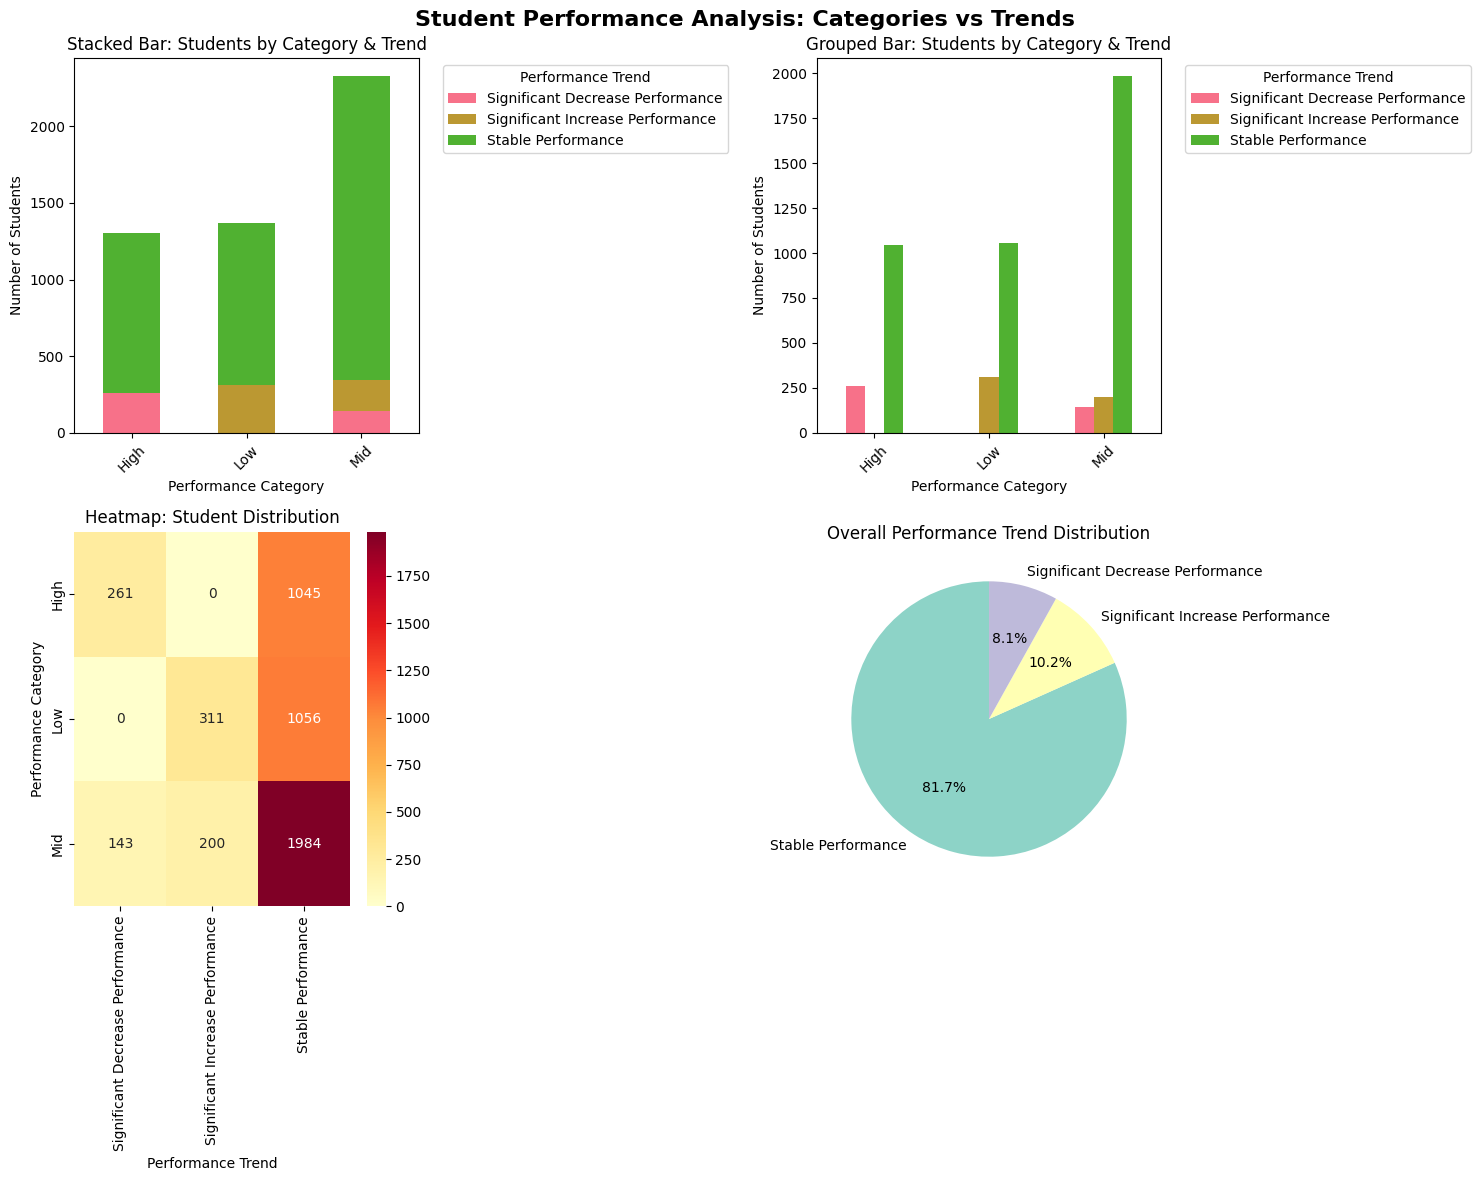

=== Detailed Breakdown ===

Low Performers:
  Stable Performance: 1056 students (77.2%)
  Significant Increase Performance: 311 students (22.8%)

Mid Performers:
  Stable Performance: 1984 students (85.3%)
  Significant Increase Performance: 200 students (8.6%)
  Significant Decrease Performance: 143 students (6.1%)

High Performers:
  Stable Performance: 1045 students (80.0%)
  Significant Decrease Performance: 261 students (20.0%)

=== Summary ===
Total Students: 5000
Low Performers: 1367
Mid Performers: 2327
High Performers: 1306


In [31]:


# Set style for better-looking plots
plt.style.use('default')
sns.set_palette("husl")

# Create figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Student Performance Analysis: Categories vs Trends', fontsize=16, fontweight='bold')

# 1. Crosstab table for exact counts
crosstab = pd.crosstab(df_final['Kategori Performa'], df_final['performance_trend'], margins=True)
print("=== Student Counts by Category and Performance Trend ===")
print(crosstab)
print("\n")

# 2. Stacked Bar Chart
ax1 = axes[0, 0]
crosstab_no_margins = pd.crosstab(df_final['Kategori Performa'], df_final['performance_trend'])
crosstab_no_margins.plot(kind='bar', stacked=True, ax=ax1, rot=45)
ax1.set_title('Stacked Bar: Students by Category & Trend')
ax1.set_xlabel('Performance Category')
ax1.set_ylabel('Number of Students')
ax1.legend(title='Performance Trend', bbox_to_anchor=(1.05, 1), loc='upper left')

# 3. Grouped Bar Chart
ax2 = axes[0, 1]
crosstab_no_margins.plot(kind='bar', ax=ax2, rot=45)
ax2.set_title('Grouped Bar: Students by Category & Trend')
ax2.set_xlabel('Performance Category')
ax2.set_ylabel('Number of Students')
ax2.legend(title='Performance Trend', bbox_to_anchor=(1.05, 1), loc='upper left')

# 4. Heatmap
ax3 = axes[1, 0]
sns.heatmap(crosstab_no_margins, annot=True, fmt='d', cmap='YlOrRd', ax=ax3)
ax3.set_title('Heatmap: Student Distribution')
ax3.set_xlabel('Performance Trend')
ax3.set_ylabel('Performance Category')

# 5. Pie Chart showing overall trend distribution
ax4 = axes[1, 1]
trend_counts = df_final['performance_trend'].value_counts()
colors = plt.cm.Set3(range(len(trend_counts)))
wedges, texts, autotexts = ax4.pie(trend_counts.values, labels=trend_counts.index, autopct='%1.1f%%', colors=colors, startangle=90)
ax4.set_title('Overall Performance Trend Distribution')

# Adjust layout
plt.tight_layout()
plt.show()

# Additional detailed breakdown
print("=== Detailed Breakdown ===")
for category in ['Low', 'Mid', 'High']:
    print(f"\n{category} Performers:")
    category_data = df_final[df_final['Kategori Performa'] == category]['performance_trend'].value_counts()
    total = category_data.sum()
    for trend, count in category_data.items():
        percentage = (count/total) * 100
        print(f"  {trend}: {count} students ({percentage:.1f}%)")

# Summary statistics
print(f"\n=== Summary ===")
print(f"Total Students: {len(df_final)}")
print(f"Low Performers: {len(df_final[df_final['Kategori Performa'] == 'Low'])}")
print(f"Mid Performers: {len(df_final[df_final['Kategori Performa'] == 'Mid'])}")
print(f"High Performers: {len(df_final[df_final['Kategori Performa'] == 'High'])}")

Average Absence Days per Student:
performance_trend  Significant Decrease Performance  \
Kategori Performa                                     
High                                            3.5   
Low                                             0.0   
Mid                                             6.2   

performance_trend  Significant Increase Performance  Stable Performance  
Kategori Performa                                                        
High                                            0.0                 0.5  
Low                                             6.0                 8.4  
Mid                                             1.1                 5.0  


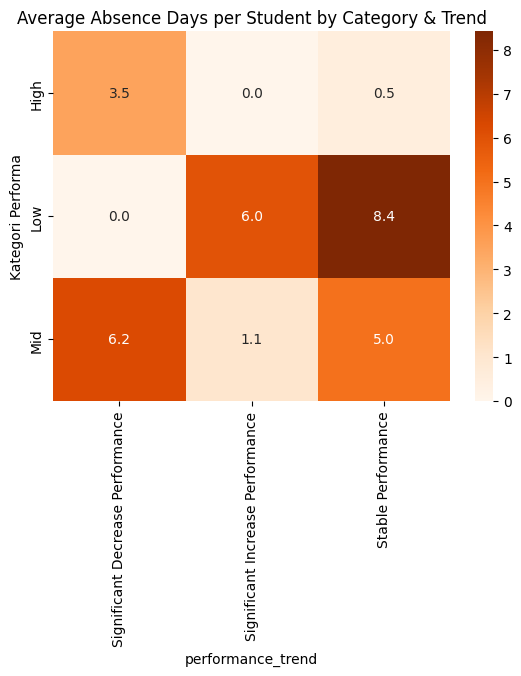

In [32]:
# Average absences per student in each group
pivot_avg = df_final.pivot_table(
    values='Jumlah Ketidakhadiran', 
    index='Kategori Performa', 
    columns='performance_trend', 
    aggfunc='mean',  # Average absences per student
    fill_value=0
)
print("Average Absence Days per Student:")
print(pivot_avg.round(1))

# Heatmap of average absences
sns.heatmap(pivot_avg, annot=True, fmt='.1f', cmap='Oranges')
plt.title('Average Absence Days per Student by Category & Trend')
plt.show()

Average Persentase Tugas per Student:
performance_trend  Significant Decrease Performance  \
Kategori Performa                                     
High                                           79.5   
Low                                             0.0   
Mid                                            54.7   

performance_trend  Significant Increase Performance  Stable Performance  
Kategori Performa                                                        
High                                            0.0                92.0  
Low                                            69.4                39.6  
Mid                                            87.0                74.4  


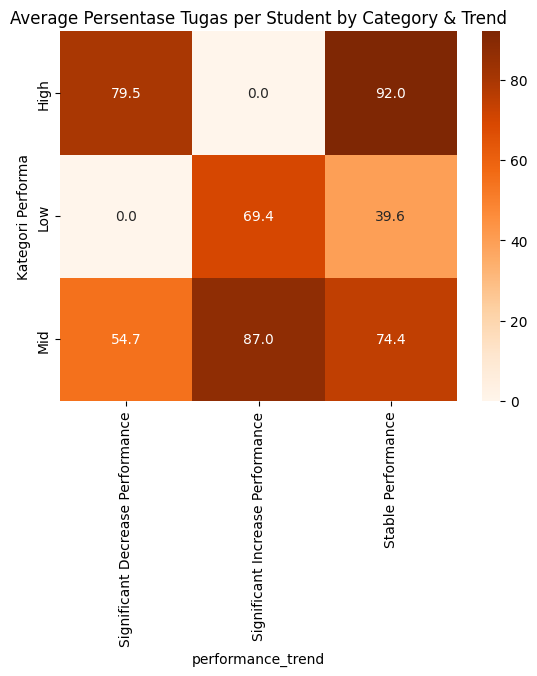

In [33]:
# Average absences per student in each group
pivot_avg = df_final.pivot_table(
    values='Persentase Tugas', 
    index='Kategori Performa', 
    columns='performance_trend', 
    aggfunc='mean',  # Average absences per student
    fill_value=0
)
print("Average Persentase Tugas per Student:")
print(pivot_avg.round(1))

# Heatmap of average absences
sns.heatmap(pivot_avg, annot=True, fmt='.1f', cmap='Oranges')
plt.title('Average Persentase Tugas per Student by Category & Trend')
plt.show()

Average All subject Rata-Rata per Student:
performance_trend  Significant Decrease Performance  \
Kategori Performa                                     
High                                           86.6   
Low                                             0.0   
Mid                                            73.4   

performance_trend  Significant Increase Performance  Stable Performance  
Kategori Performa                                                        
High                                            0.0                92.1  
Low                                            67.0                60.4  
Mid                                            82.4                76.6  


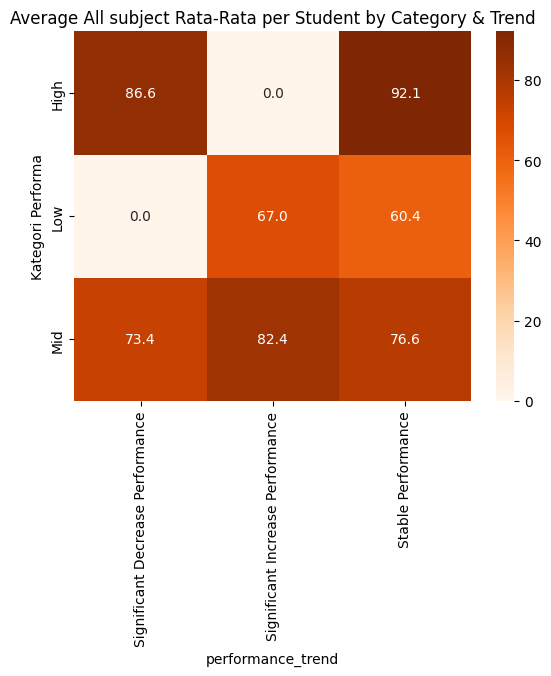

In [34]:
# Average absences per student in each group
pivot_avg = df_final.pivot_table(
    values='Rata-rata', 
    index='Kategori Performa', 
    columns='performance_trend', 
    aggfunc='mean',  # Average absences per student
    fill_value=0
)
print("Average All subject Rata-Rata per Student:")
print(pivot_avg.round(1))

# Heatmap of average absences
sns.heatmap(pivot_avg, annot=True, fmt='.1f', cmap='Oranges')
plt.title('Average All subject Rata-Rata per Student by Category & Trend')
plt.show()

## Export Load Data

In [35]:
df_final.to_csv('daftar_nilai_final5.csv', index=False)

## Reference Code

In [36]:
# # Re-import necessary modules after code execution environment reset
# import pandas as pd
# import numpy as np

# np.random.seed(42)

# # daftar subjek
# subjects = [
#     "Pendidikan Agama", "Pendidikan Pancasila", "Bahasa Inggris", "Bahasa Mandarin",
#     "Matematika (Umum)", "Biologi", "Fisika", "Kimia", "Geografi", "Sejarah",
#     "Sosiologi", "Ekonomi", "Pendidikan Jasmani, Olahraga, dan Kesehatan",
#     "Informatika", "Seni Musik", "Bahasa Indonesia"
# ]

# # students yang bakal di generate
# n_students = 1000

# # Simulasi semester sekarang
# low_count = int(0.2 * n_students)
# mid_count = int(0.5 * n_students)
# high_count = n_students - low_count - mid_count

# low_avg = np.random.normal(loc=60, scale=5, size=low_count)
# mid_avg = np.random.normal(loc=75, scale=5, size=mid_count)
# high_avg = np.random.normal(loc=90, scale=5, size=high_count)

# base_averages = np.concatenate([low_avg, mid_avg, high_avg])
# base_averages = np.clip(base_averages, 0, 100)

# # Simulasi skor subjek per murid
# grades_current = np.array([
#     base + np.random.normal(loc=0, scale=5, size=len(subjects))
#     for base in base_averages
# ])
# grades_current = np.clip(grades_current, 0, 100)

# # dataframe
# df = pd.DataFrame(grades_current, columns=subjects)
# df['Rata-rata'] = df.mean(axis=1)

# # Mask
# low_mask = df['Rata-rata'] < 70
# mid_mask = (df['Rata-rata'] >= 70) & (df['Rata-rata'] < 85)
# high_mask = df['Rata-rata'] >= 85

# df_next_sem = df[subjects].copy()

# def add_noise(data, loc=0, scale=5):
#     return np.clip(data + np.random.normal(loc=loc, scale=scale, size=data.shape), 0, 100)

# # Low performers
# indices = df[low_mask].index.to_numpy()
# np.random.shuffle(indices)
# n = len(indices)
# df_next_sem.loc[indices[:int(0.7 * n)]] = add_noise(df_next_sem.loc[indices[:int(0.7 * n)]], loc=5, scale=4)
# df_next_sem.loc[indices[int(0.7 * n):int(0.9 * n)]] = add_noise(df_next_sem.loc[indices[int(0.7 * n):int(0.9 * n)]], loc=0, scale=3)
# df_next_sem.loc[indices[int(0.9 * n):]] = add_noise(df_next_sem.loc[indices[int(0.9 * n):]], loc=15, scale=5)

# # Mid performers
# indices = df[mid_mask].index.to_numpy()
# np.random.shuffle(indices)
# n = len(indices)
# df_next_sem.loc[indices[:int(0.6 * n)]] = add_noise(df_next_sem.loc[indices[:int(0.6 * n)]], loc=0, scale=3)
# df_next_sem.loc[indices[int(0.6 * n):int(0.9 * n)]] = add_noise(df_next_sem.loc[indices[int(0.6 * n):int(0.9 * n)]], loc=5, scale=4)
# df_next_sem.loc[indices[int(0.9 * n):]] = add_noise(df_next_sem.loc[indices[int(0.9 * n):]], loc=-7, scale=5)

# # High performers
# indices = df[high_mask].index.to_numpy()
# np.random.shuffle(indices)
# n = len(indices)
# df_next_sem.loc[indices[:int(0.8 * n)]] = add_noise(df_next_sem.loc[indices[:int(0.8 * n)]], loc=-3, scale=3)
# df_next_sem.loc[indices[int(0.8 * n):]] = add_noise(df_next_sem.loc[indices[int(0.8 * n):]], loc=0, scale=2)

# # pembulatan dan pergantian nama df
# df_next_sem = df_next_sem.round().astype(int)
# df_next_sem.columns = [col + " (Next Sem)" for col in df_next_sem.columns]

# # kombinasi
# df_final = pd.concat([df, df_next_sem], axis=1)
# df_final['Rata-rata (Next Sem)'] = df_next_sem.mean(axis=1).round(2)

# # Kategori berdasarkan performa dan perubahan
# df_final['Kategori Performa'] = "Unlabeled"
# df_final.loc[low_mask, 'Kategori Performa'] = "Low"
# df_final.loc[mid_mask, 'Kategori Performa'] = "Mid"
# df_final.loc[high_mask, 'Kategori Performa'] = "High"

# # Kategori perubahan
# df_final['Kategori Performa (Next)'] = pd.cut(
#     df_final['Rata-rata (Next Sem)'],
#     bins=[-1, 70, 85, 100],
#     labels=["Low", "Mid", "High"]
# )

# # Tambahkan jumlah ketidakhadiran berdasarkan kategori performa
# def generate_absences(current, future):
#     if current == "Low" and future == "High":
#         return np.random.randint(0, 4)
#     elif current == "Low" and future == "Low":
#         return np.random.randint(7, 16)
#     elif current == "Mid" and future == "Mid":
#         return np.random.randint(2, 9)
#     elif current == "Mid" and future == "High":
#         return np.random.randint(0, 7)
#     elif current == "High":
#         return np.random.randint(0, 5)
#     else:
#         return np.random.randint(1, 10)

# df_final['Jumlah Ketidakhadiran'] = df_final.apply(
#     lambda row: generate_absences(row['Kategori Performa'], row['Kategori Performa (Next)']),
#     axis=1
# )

# df_final[['Kategori Performa', 'Kategori Performa (Next)', 'Jumlah Ketidakhadiran']].value_counts().head(10)
